# Iris Dataset

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Loading Iris dataset into DataDrame

In [2]:
df_iris= pd.read_csv('iris.data',names=[ 'sepal_length','sepal_width','petal_length','petal_width','class1'])

In [3]:
df_iris.head(3)

,sepal_length,sepal_width,petal_length,petal_width,class1
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


In [4]:
cat={'Iris-setosa':0, 'Iris-versicolor':1,'Iris-virginica':2}
df_iris['class1'] = [cat[i] for i in df_iris['class1']]
#df_iris['class1']=df_iris['class1'].map('Iris-setosa':1, 'Iris-Versicolour':2,'Iris-Virginica':3)
df_iris.dropna(inplace=True)

In [5]:
df_iris.shape

(150, 5)

### Splitting Dataset into Train test set 

In [6]:
X_train,X_test,y_train,y_test = train_test_split(df_iris[['sepal_length','sepal_width','petal_length','petal_width']],df_iris['class1'],test_size=0.2)

In [7]:
scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)


In [8]:
class Loaddataset(Dataset):
    def __init__(self,data,class1):
        self.data=torch.from_numpy(data).float()
        self.class1=torch.from_numpy(class1.to_numpy()).long()
        
    def __len__(self):
        return len(self.class1)
    
    def __getitem__(self,idx):
        data=self.data[idx]
        class1=self.class1[idx]
        return data,class1

In [9]:
training_data= Loaddataset(X_train,y_train)
testing_data = Loaddataset(X_test,y_test)

In [10]:
batch_size=64

traindataloader=DataLoader(training_data,batch_size=batch_size)
testdataloader=DataLoader(testing_data,batch_size=batch_size)

In [11]:
X, y = next(iter(traindataloader))
X.shape, y.shape

(torch.Size([64, 4]), torch.Size([64]))

In [12]:
class Ada_act(nn.Module):
    def __init__(self,k1,k2):
        super(Ada_act,self).__init__()
        self.k=torch.nn.Parameter(torch.tensor([k1,k2]))
        
    def forward(self,x):
        return self.k[0]+(self.k[1]*x)

In [13]:
class custom(nn.Module):
    def __init__(self,input_dim,k1,k2):
        super(custom,self).__init__()
        self.layer1 =nn.Linear(input_dim,100)
        self.layer2 = nn.Linear(100,200)
        self.layer3 = nn.Linear(200,3)
        self.Ada_act = Ada_act(k1,k2)
    def forward(self,x):
        x= self.Ada_act(self.layer1(x))
        x= self.Ada_act(self.layer2(x))
        x= F.softmax(self.layer3(x),dim=1)
        return x

In [14]:
print(custom(4, 0.5, 0.5))

custom(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=200, bias=True)
  (layer3): Linear(in_features=200, out_features=3, bias=True)
  (Ada_act): Ada_act()
)


In [15]:
def training(dataloader,model,loss_function,optimizer):
    train_loss =[]
    pred_all =[]
    for batch,(X,y) in enumerate(dataloader):
        X,y= X.to(device),y.to(device)
        
        pred = model(X)
        loss = loss_function(pred,y)
        
        train_loss.append(loss.item())
        
        pred_all = pred_all + pred.argmax(1).tolist()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    train_accuracy = metrics.accuracy_score(dataloader.dataset.class1,pred_all)
    return (sum(train_loss)/len(train_loss),train_accuracy)

In [16]:
def testing(dataloader,model):
    model.eval()
    testing_loss =[]
    pred_all =[]
    test_loss = 0
    with torch.no_grad():
        for batch, (X,y) in enumerate(dataloader):
            
            X,y = X.to(device),y.to(device)


            pred =model(X)
            loss = loss_function(pred,y).item()


            test_loss = test_loss + loss
            pred_all = pred_all + pred.argmax(1).tolist()

    test_loss =test_loss/ len(dataloader)
        
    test_accuracy = metrics.accuracy_score(dataloader.dataset.class1,pred_all)
    test_F1_score = metrics.f1_score(dataloader.dataset.class1,pred_all, average='micro')
        
    return (test_loss, test_accuracy,test_F1_score)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [18]:
k1=0.5
k2=0.7

model = custom(training_data.data.shape[1],k1,k2).to(device)
loss_function = nn.CrossEntropyLoss()
Adam_optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

epochs =300
train_info =[]
test_info = []
    
print('---------------------------------------Training Started-------------------------------------------\n')
for epoch in tqdm(range(epochs)):
    training_epoch_1 = training(traindataloader, model, loss_function, Adam_optimizer)
    Validating_epoch_1 = testing(testdataloader, model)
    
    train_info.append(training_epoch_1)
    test_info.append(Validating_epoch_1)
    if epoch % 10 == 0:
        print('Epochs',epoch)
        print('Training LOSS',training_epoch_1[0])
        print('Training Accuracy',training_epoch_1[1])
        print('Validating Loss',Validating_epoch_1[0])
        print('Validating Accuracy',Validating_epoch_1[1])
print("Completed!")    

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

---------------------------------------Training Started-------------------------------------------



  6%|████▌                                                                            | 17/300 [00:00<00:04, 57.46it/s]

Epochs 0
Training LOSS 1.1173876523971558
Training Accuracy 0.20833333333333334
Validating Loss 1.059059739112854
Validating Accuracy 0.4
Epochs 10
Training LOSS 0.7553520798683167
Training Accuracy 0.875
Validating Loss 0.7501541376113892
Validating Accuracy 0.8666666666666667
Epochs 20
Training LOSS 0.6663018763065338
Training Accuracy 0.925
Validating Loss 0.6600879430770874
Validating Accuracy 0.9333333333333333
Epochs 30
Training LOSS 0.6154309809207916
Training Accuracy 0.9583333333333334
Validating Loss 0.610995352268219
Validating Accuracy 1.0


 22%|█████████████████▌                                                              | 66/300 [00:00<00:01, 126.81it/s]

Epochs 40
Training LOSS 0.5903510451316833
Training Accuracy 0.975
Validating Loss 0.6081850528717041
Validating Accuracy 0.9666666666666667
Epochs 50
Training LOSS 0.5815808773040771
Training Accuracy 0.975
Validating Loss 0.5987054109573364
Validating Accuracy 0.9666666666666667
Epochs 60
Training LOSS 0.5774610936641693
Training Accuracy 0.975
Validating Loss 0.5913773775100708
Validating Accuracy 0.9666666666666667
Epochs 70
Training LOSS 0.5751113891601562
Training Accuracy 0.975
Validating Loss 0.5906038880348206
Validating Accuracy 0.9666666666666667


 32%|█████████████████████████▌                                                      | 96/300 [00:00<00:01, 115.32it/s]

Epochs 80
Training LOSS 0.5734890997409821
Training Accuracy 0.9833333333333333
Validating Loss 0.5912158489227295
Validating Accuracy 0.9666666666666667
Epochs 90
Training LOSS 0.5722245872020721
Training Accuracy 0.9916666666666667
Validating Loss 0.5917235016822815
Validating Accuracy 0.9666666666666667


 36%|████████████████████████████▋                                                  | 109/300 [00:01<00:01, 110.58it/s]

Epochs 100
Training LOSS 0.5711503028869629
Training Accuracy 0.9916666666666667
Validating Loss 0.5923616290092468
Validating Accuracy 0.9666666666666667
Epochs 110
Training LOSS 0.5701838731765747
Training Accuracy 0.9916666666666667
Validating Loss 0.5930396914482117
Validating Accuracy 0.9666666666666667
Epochs 120
Training LOSS 0.5692837536334991
Training Accuracy 0.9916666666666667
Validating Loss 0.5935559868812561
Validating Accuracy 0.9666666666666667


 51%|████████████████████████████████████████                                       | 152/300 [00:01<00:01, 128.56it/s]

Epochs 130
Training LOSS 0.5684302747249603
Training Accuracy 0.9916666666666667
Validating Loss 0.5938759446144104
Validating Accuracy 0.9666666666666667
Epochs 140
Training LOSS 0.5676161646842957
Training Accuracy 0.9916666666666667
Validating Loss 0.5939948558807373
Validating Accuracy 0.9666666666666667
Epochs 150
Training LOSS 0.566841334104538
Training Accuracy 0.9916666666666667
Validating Loss 0.5939196348190308
Validating Accuracy 0.9666666666666667
Epochs 160
Training LOSS 0.5661095678806305
Training Accuracy 0.9916666666666667

 61%|████████████████████████████████████████████████▏                              | 183/300 [00:01<00:00, 140.24it/s]


Validating Loss 0.59367835521698
Validating Accuracy 0.9666666666666667
Epochs 170
Training LOSS 0.565425455570221
Training Accuracy 0.9916666666666667
Validating Loss 0.5933021903038025
Validating Accuracy 0.9666666666666667
Epochs 180
Training LOSS 0.5647936463356018
Training Accuracy 0.9916666666666667
Validating Loss 0.5928261876106262
Validating Accuracy 0.9666666666666667


 66%|████████████████████████████████████████████████████▏                          | 198/300 [00:01<00:00, 126.30it/s]

Epochs 190
Training LOSS 0.5642169117927551
Training Accuracy 0.9916666666666667
Validating Loss 0.5922840237617493
Validating Accuracy 0.9666666666666667
Epochs 200
Training LOSS 0.5636960566043854
Training Accuracy 0.9916666666666667
Validating Loss 0.5917069911956787
Validating Accuracy 0.9666666666666667
Epochs 210
Training LOSS 0.5632299184799194
Training Accuracy 0.9916666666666667
Validating Loss 0.5911216735839844
Validating Accuracy 0.9666666666666667


 81%|███████████████████████████████████████████████████████████████▋               | 242/300 [00:02<00:00, 130.34it/s]

Epochs 220
Training LOSS 0.5628158152103424
Training Accuracy 0.9916666666666667
Validating Loss 0.5905488729476929
Validating Accuracy 0.9666666666666667
Epochs 230
Training LOSS 0.5624497830867767
Training Accuracy 0.9916666666666667
Validating Loss 0.5900037884712219
Validating Accuracy 0.9666666666666667
Epochs 240
Training LOSS 0.562127411365509
Training Accuracy 0.9916666666666667
Validating Loss 0.5894968509674072
Validating Accuracy 0.9666666666666667
Epochs 250
Training LOSS 0.5618438124656677
Training Accuracy 0.9916666666666667
Validating Loss 0.5890336632728577
Validating Accuracy 0.9666666666666667


 97%|████████████████████████████████████████████████████████████████████████████▋  | 291/300 [00:02<00:00, 148.09it/s]

Epochs 260
Training LOSS 0.5615947246551514
Training Accuracy 0.9916666666666667
Validating Loss 0.588616132736206
Validating Accuracy 0.9666666666666667
Epochs 270
Training LOSS 0.5613755285739899
Training Accuracy 0.9916666666666667
Validating Loss 0.588244616985321
Validating Accuracy 0.9666666666666667
Epochs 280
Training LOSS 0.5611826181411743
Training Accuracy 0.9916666666666667
Validating Loss 0.587916374206543
Validating Accuracy 0.9666666666666667
Epochs 290
Training LOSS 0.561012327671051
Training Accuracy 0.9916666666666667
Validating Loss 0.5876289010047913
Validating Accuracy 0.9666666666666667


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 121.54it/s]

Completed!


# Plotting the Results

Text(0, 0.5, 'Validation Accuracy')

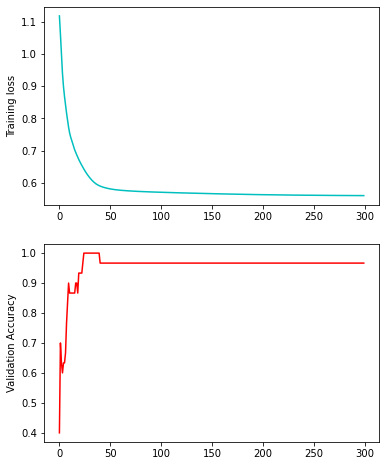

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 8))

ax1.plot(list(zip(*train_info))[0],'c')
ax1.set_ylabel("Training loss")
ax2.plot(list(zip(*test_info))[1],'red')
ax2.set_ylabel("Validation Accuracy")